In [1]:
%load_ext Cython

In [2]:
%%cython

import numpy as np
from scipy.optimize import brentq

cimport cython
cimport numpy as np
from libc.math cimport log, sqrt

cdef inline float float_max(float a, float b): return a if a >= b else b
cdef inline float float_min(float a, float b): return a if a <= b else b

ctypedef np.float_t DTYPE_t

@cython.cdivision(True)
cpdef float cython_get_antropogenic_release(float xt, float c1, float c2, float r1, 
                             float r2, float w1):
    '''
    
    Parameters
    ----------
    xt : float
         polution in lake at time t
    c1 : float
         center rbf 1
    c2 : float
         center rbf 2
    r1 : float
         ratius rbf 1
    r2 : float
         ratius rbf 2
    w1 : float
         weight of rbf 1
         
    note:: w2 = 1 - w1
    
    '''
    cdef float rule, at, var1, var2, test
    
    var1 = (xt-c1)/r1
    var1 = abs(var1)
    var2 = (xt-c2)/r2
    var2 = abs(var2)
    
    rule = w1*(var1**3)+(1-w1)*(var2**3)
    at = float_min(float_max(rule, 0.01), 0.1)
    return at
    
@cython.cdivision(True)
@cython.boundscheck(False) 
def cython_lake_model(float b=0.42, float q=2.0, float mean=0.02, float stdev=0.001, 
               float alpha=0.4, float delta=0.98, float c1=0.25,
               float c2=0.25, float r1=0.5, float r2=0.5, float w1=0.5, 
               int nsamples=100, int steps=100):    
    '''runs the lake model for 1 stochastic realisation using specified 
    random seed.
        
    Parameters
    ----------
    b : float
        decay rate for P in lake (0.42 = irreversible)
    q : float
        recycling exponent
    mean : float
            mean of natural inflows
    stdev : float
            standard deviation of natural inflows
    alpha : float
            utility from pollution
    delta : float
            future utility discount rate
    c1 : float
    c2 : float
    r1 : float
    r2 : float
    w1 : float
    steps : int
            the number of time steps (e.g., days)
    seed : int, optional
           seed for the random number generator
    
    '''
    cdef float Pcrit, reliability, utility, inertia, transformed_mean, transformed_sigma
    cdef int t
    cdef np.ndarray[DTYPE_t, ndim=1] X = np.zeros([steps,], dtype=np.float)
    cdef np.ndarray[DTYPE_t, ndim=1] decisions = np.zeros([steps,], dtype=np.float)
    cdef np.ndarray[DTYPE_t, ndim=1] natural_inflows 
    
#     np.random.seed(seed)
    Pcrit = brentq(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    
    transformed_mean = log(mean**2 / sqrt(stdev**2 + mean**2))
    transformed_sigma = sqrt(log(1.0 + stdev**2 / mean**2))
    natural_inflows = np.random.lognormal(transformed_mean, transformed_sigma, size=steps)

    for t in range(1, steps):
        decisions[t-1] = cython_get_antropogenic_release(X[t-1], c1, c2, r1, r2, 
                                                  w1)
        X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]

    reliability = np.sum(X < Pcrit)/steps
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(steps)))
    inertia = np.sum(np.abs(np.diff(decisions)) < 0.01)/(steps-1)
    return X, utility, inertia, reliability

In [3]:
from ema_workbench import (RealParameter, ScalarOutcome, Constant)
from ema_workbench.em_framework.model import Replicator, BaseModel

#instantiate the model
class ReplicatorModel(Replicator, BaseModel):
    pass
lake_model = ReplicatorModel('lakeproblem', function=cython_lake_model)
lake_model.replications = 150

#specify uncertainties
lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

# set levers
lake_model.levers = [RealParameter("c1", -2, 2),
                     RealParameter("c2", -2, 2),
                     RealParameter("r1", 0, 2), 
                     RealParameter("r2", 0, 2), 
                     RealParameter("w1", 0, 1)
                     ]

def process_p(values):
    values = np.asarray(values)
    values = np.mean(values, axis=0)
    return np.max(values)

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', 
                                     kind=ScalarOutcome.MINIMIZE,
                                     function=process_p),
                       ScalarOutcome('utility', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean),
                       ScalarOutcome('inertia', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean),
                       ScalarOutcome('reliability', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean)]

# override some of the defaults of the model
lake_model.constants = [Constant('alpha', 0.41),
                        Constant('nsamples', 100),
                        Constant('steps', 100)]

In [4]:
# how many scenarios do we need

In [5]:
from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                           perform_experiments, save_results, load_results)

ema_logging.log_to_stderr(ema_logging.INFO)

try:
    results = load_results('./data/learning random policies.tar.gz')
except IOError:
    with MultiprocessingEvaluator(lake_model) as evaluator:
        results = evaluator.perform_experiments(scenarios=1000, policies=10)
    save_results(results, './data/learning random policies.tar.gz')

[MainProcess/INFO] results loaded succesfully from /Domain/tudelft.net/Users/jhkwakkel/Documents/workspace/resilience17/data/learning random policies.tar.gz


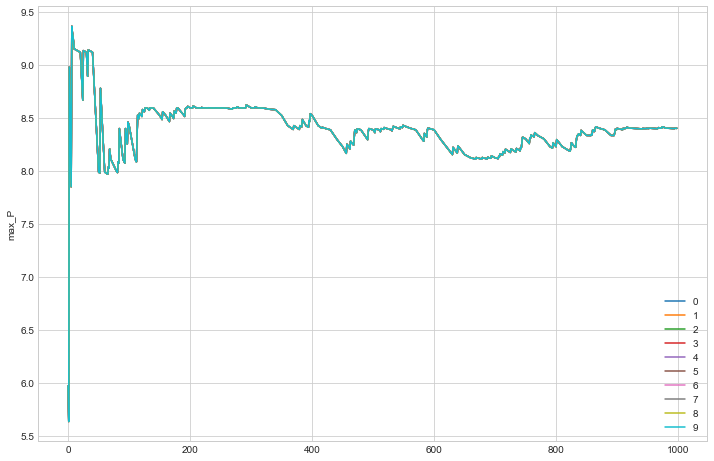

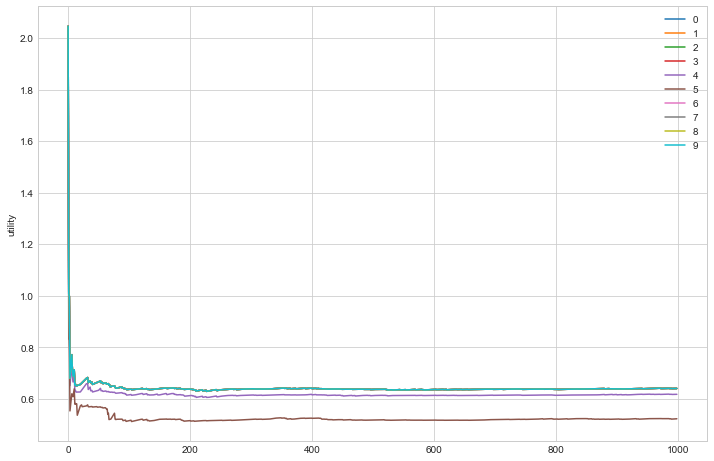

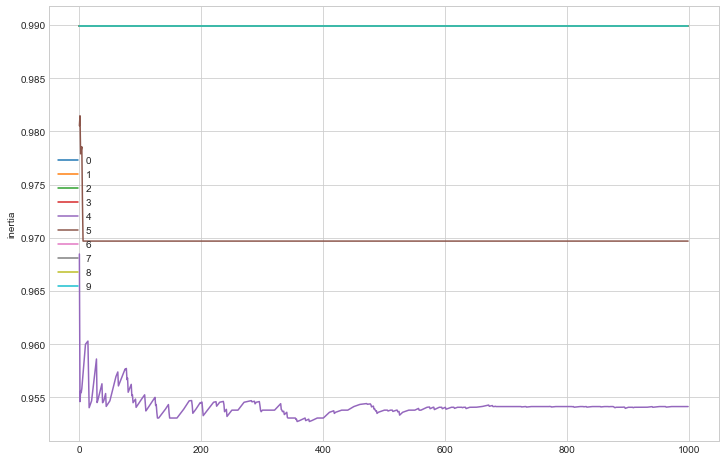

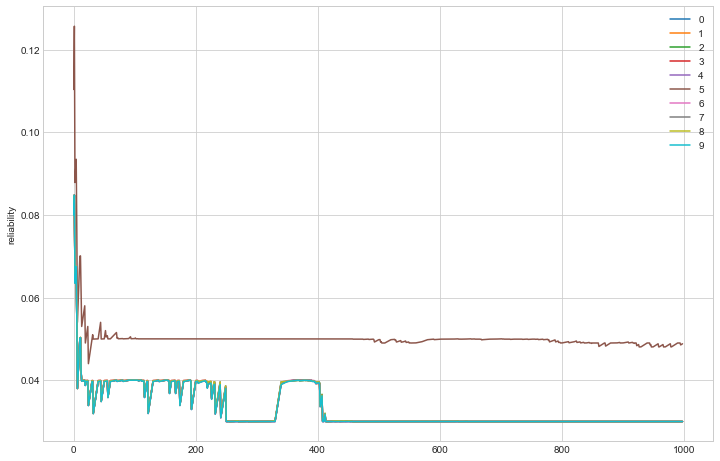

In [6]:
import functools
experiments, outcomes = results

for name, outcome in outcomes.items():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_ylabel(name)
    
    if name == 'max_P':
        robustness_func = functools.partial(np.percentile, q=90)
    else:
        robustness_func = functools.partial(np.percentile, q=10)
    
    for i, policy in enumerate(set(experiments['policy'])):
        logical = experiments['policy']==policy
        data = outcome[logical]
        robustness = []
        for j in range(1, data.shape[0]):
            robustness.append(robustness_func(data[0:j]))
            
        ax.plot(robustness, label=str(i))
    ax.legend()
plt.show()
            


In [8]:
from ema_workbench.em_framework.optimization import to_dataframe
from ema_workbench.em_framework.samplers import sample_uncertainties

class Callback(object):
    '''Callable object for tracking progress of optimization over generations
    '''

    def __init__(self):
        self.progress = []
        self.archive_history = []

    def __call__(self, optimizer):
        self.progress.append(optimizer.algorithm.archive.improvements)
        
        dvnames = optimizer.problem.parameter_names
        outcome_names = optimizer.problem.outcome_names
        
        self.archive_history.append(to_dataframe(optimizer, dvnames,
                                                 outcome_names))
callback = Callback()


percentile10 = functools.partial(np.percentile, q=10)
percentile90 = functools.partial(np.percentile, q=90)

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE
robustnes_functions = [ScalarOutcome('90th percentile max_p', kind=MINIMIZE, 
                             variable_name='max_P', function=percentile90),
                       ScalarOutcome('10th percentile reliability', kind=MAXIMIZE, 
                             variable_name='reliability', function=percentile10),
                       ScalarOutcome('10th percentile inertia', kind=MAXIMIZE, 
                             variable_name='inertia', function=percentile10),
                       ScalarOutcome('10th percentile utility', kind=MAXIMIZE, 
                             variable_name='utility', function=percentile10)]


n_scenarios = 200
scenarios = sample_uncertainties(lake_model, n_scenarios)
nfe = 10000

with MultiprocessingEvaluator(lake_model) as evaluator:
    robust_results = evaluator.robust_optimize(robustnes_functions, 
                            scenarios, nfe=nfe, population_size=25,
                            epsilons=[0.05,]*len(robustnes_functions),
                            callback=callback)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 200 scenarios * 25 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO]

[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 25 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProce

[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProce

[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProce

[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 25 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProce

[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProce

[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 25 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProce

[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProce

[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 25 policies * 1 model(s) = 5000 experiments
[MainProce

[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProce

[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProce

[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 25 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 26 policies * 1 model(s) = 5200 experiments
[MainProce

[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 2080 cases completed
[MainProcess/INFO] 3120 cases completed
[MainProcess/INFO] 4160 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 30 policies * 1 model(s) = 6000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 40 policies * 1 model(s) = 8000 experiments
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 40 policies * 1 model(s) = 8000 experiments
[MainProce

[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 40 policies * 1 model(s) = 8000 experiments
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 40 policies * 1 model(s) = 8000 experiments
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 40 policies * 1 model(s) = 8000 experiments
[MainProce

[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 40 policies * 1 model(s) = 8000 experiments
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 40 policies * 1 model(s) = 8000 experiments
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 200 scenarios * 40 policies * 1 model(s) = 8000 experiments
[MainProce

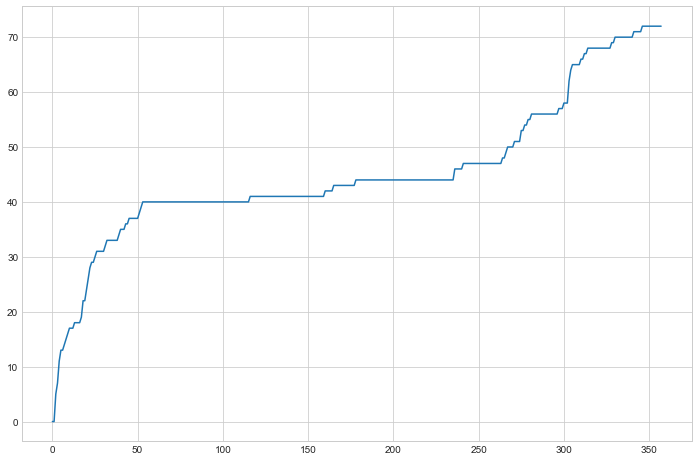

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(callback.progress)
plt.show()

In [10]:
robust_results.to_csv('./data/robust.csv')

In [13]:
from io import StringIO, BytesIO
import tarfile

base = 'robust'

file_name = './data/{}_archives.tar.gz'.format(base)
with tarfile.open(file_name, 'w:gz') as z:
    for i, entry in enumerate(callback.archive_history):
        file_buffer = StringIO()
        entry.to_csv(file_buffer)
        
        csv_as_string = file_buffer.getvalue()
        fh = BytesIO(csv_as_string.encode('UTF-8'))
        tarinfo = tarfile.TarInfo(str(i)+'.csv')
        tarinfo.size = len(csv_as_string)
        
        z.addfile(tarinfo, fh)